<a href="https://colab.research.google.com/github/Laksopan23/Brain-Tumor-Detection-Models/blob/shajeeh-inception_v3/InceptionV3TL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Setup & Import Required Libraries

In [ ]:
# ============================================
# Phase 1: Setup & Library Imports
# ============================================

# Mount Google Drive if needed (Optional)
from google.colab import drive
drive.mount('/content/drive')

# Import Python libraries
import os, random, shutil
from pathlib import Path
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.inception_v3 import InceptionV3, preprocess_input
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

SEED = 42
random.seed(SEED); np.random.seed(SEED)

print("Environment ready")


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Environment ready


## 🧰 Phase 2: Dataset Preparation

In [ ]:
# ============================================
# Phase 2: Dataset Preparation (Train/Val/Test)
# ============================================

SRC = Path("/content/drive/MyDrive/DL_Project")  # <- your Drive folder
TARGET = Path("/content/brain-tumor-yolo")       # organized output
CLASSES = ["glioma", "meningioma", "pituitary", "notumor"]

if TARGET.exists():
    shutil.rmtree(TARGET)

for split in ["train","val","test"]:
    for cls in CLASSES:
        (TARGET/split/cls).mkdir(parents=True, exist_ok=True)

def is_valid_image(p: Path):
    try:
        with Image.open(p) as im: im.verify()
        return True
    except Exception:
        return False

train_ratio, val_ratio, test_ratio = 0.7, 0.2, 0.1

for cls in CLASSES:
    src_dir = SRC/cls
    if not src_dir.exists():
        raise FileNotFoundError(f"Missing folder in Drive: {src_dir}")
    files = [p for p in src_dir.iterdir() if p.is_file() and is_valid_image(p)]
    random.shuffle(files)
    n = len(files); n_train = int(n*train_ratio); n_val = int(n*val_ratio)
    train_files = files[:n_train]; val_files = files[n_train:n_train+n_val]; test_files = files[n_train+n_val:]
    for p in train_files: shutil.copy2(p, TARGET/"train"/cls/p.name)
    for p in val_files:   shutil.copy2(p, TARGET/"val"/cls/p.name)
    for p in test_files:  shutil.copy2(p, TARGET/"test"/cls/p.name)

print("Dataset organized into train / val / test")
for split in ["train","val","test"]:
    for cls in CLASSES:
        print(f"{split}/{cls}: {len(list((TARGET/split/cls).glob('*')))} images")

Dataset organized into train / val / test
train/glioma: 1134 images
train/meningioma: 1151 images
train/pituitary: 1229 images
train/notumor: 1400 images
val/glioma: 324 images
val/meningioma: 329 images
val/pituitary: 351 images
val/notumor: 400 images
test/glioma: 163 images
test/meningioma: 165 images
test/pituitary: 177 images
test/notumor: 200 images


## 🧪 Phase 3: Data Visualization (Samples)

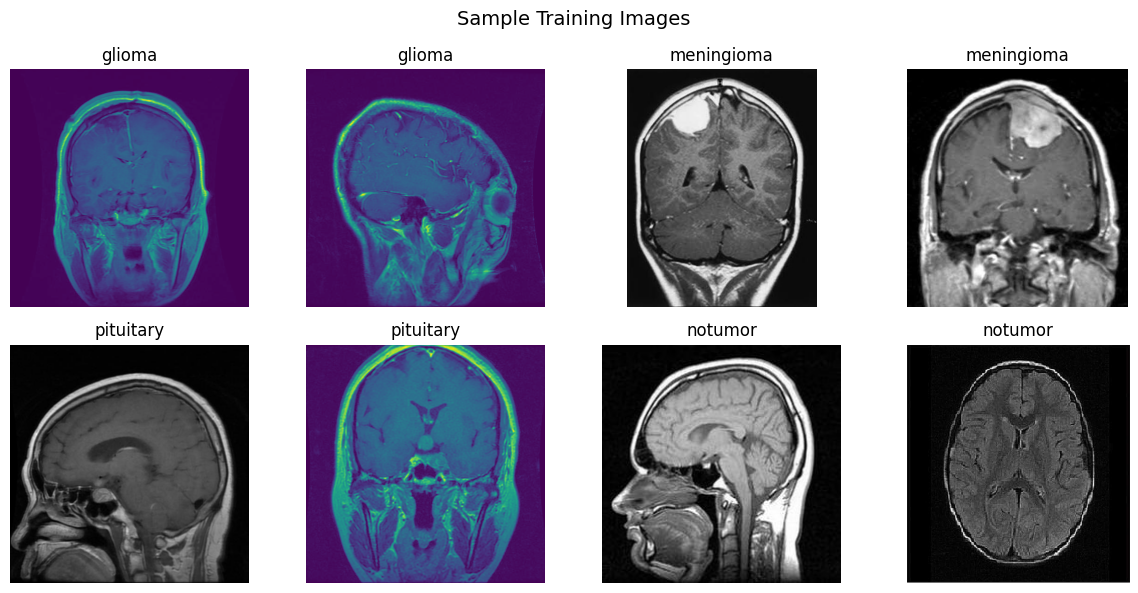

In [ ]:
# ============================================
# Phase 3: Quick Visualization of Images
# ============================================

sample_paths = []
for cls in CLASSES:
    sample_paths += list((TARGET/"train"/cls).glob("*"))[:2]

plt.figure(figsize=(12,6))
for i, img_path in enumerate(sample_paths):
    img = Image.open(img_path)
    plt.subplot(2,4,i+1)
    plt.imshow(img)
    plt.axis('off')
    plt.title(CLASSES[i//2])
plt.suptitle("Sample Training Images", fontsize=14)
plt.tight_layout()
plt.show()

## 🧠 Phase 4: Data Generators (Preprocessing)

In [ ]:
# ============================================
# Phase 4: Data Generators & Preprocessing
# ============================================

IMG_SIZE = (299, 299)   # InceptionV3 default
BATCH_SIZE = 32

train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    rotation_range=20, width_shift_range=0.2, height_shift_range=0.2,
    shear_range=0.15, zoom_range=0.15, horizontal_flip=True, fill_mode='nearest'
)
val_test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

train_gen = train_datagen.flow_from_directory(
    TARGET/"train", target_size=IMG_SIZE, batch_size=BATCH_SIZE, class_mode='categorical', seed=SEED
)
val_gen = val_test_datagen.flow_from_directory(
    TARGET/"val", target_size=IMG_SIZE, batch_size=BATCH_SIZE, class_mode='categorical', shuffle=False
)
test_gen = val_test_datagen.flow_from_directory(
    TARGET/"test", target_size=IMG_SIZE, batch_size=BATCH_SIZE, class_mode='categorical', shuffle=False
)

print("Data generators ready")

Found 4914 images belonging to 4 classes.
Found 1404 images belonging to 4 classes.
Found 705 images belonging to 4 classes.
Data generators ready


## Build InceptionV3 Model

In [ ]:
# ============================================
# Phase 5: Build InceptionV3  Transfer Learning Model
# ============================================

base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(299,299,3))
for layer in base_model.layers:
    layer.trainable = False  # freeze for initial training

x = GlobalAveragePooling2D()(base_model.output)
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)
output = Dense(4, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=output)
model.compile(optimizer=Adam(learning_rate=1e-4), loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()


87910968/87910968 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 299, 299,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 149, 149,  │        864 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 149, 149,  │         96 │ conv2d[0][0]      │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 149, 149,  │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 147, 147,  │      9,216 │ activation[0][0]  │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 147, 147,  │         96 │ conv2d_1[0][0]    │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_1        │ (None, 147, 147,  │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 147, 147,  │     18,432 │ activation_1[0][… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 147, 147,  │        192 │ conv2d_2[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_2        │ (None, 147, 147,  │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 73, 73,    │          0 │ activation_2[0][… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 73, 73,    │      5,120 │ max_pooling2d[0]… │
│                     │ 80)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 73, 73,    │        240 │ conv2d_3[0][0]    │
│ (BatchNormalizatio… │ 80)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_3        │ (None, 73, 73,    │          0 │ batch_normalizat… │
│ (Activation)        │ 80)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 71, 71,    │    138,240 │ activation_3[0][… │
│                     │ 192)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 71, 71,    │        576 │ conv2d_4[0][0]    │
│ (BatchNormalizatio… │ 192)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_4        │ (None, 71, 71,    │          0 │ batch_normalizat

 Total params: 22,328,356 (85.18 MB)

 Trainable params: 525,572 (2.00 MB)

 Non-trainable params: 21,802,784 (83.17 MB)

##
🚀 Phase 6: Callbacks and Training
python
Copy code


In [ ]:
# ============================================
# Phase 6: Training Setup & Callbacks
# ============================================

callbacks = [
    EarlyStopping(monitor='val_loss', patience=6, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.3, patience=3, min_lr=1e-6, verbose=1),
    ModelCheckpoint("best_inceptionv3_model.h5", save_best_only=True, monitor='val_accuracy', mode='max', verbose=1)
]

EPOCHS = 30

history = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=EPOCHS,
    callbacks=callbacks
)

print("Training completed")

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/30
154/154 ━━━━━━━━━━━━━━━━━━━━ 0s 766ms/step - accuracy: 0.5209 - loss: 1.1128
Epoch 1: val_accuracy improved from -inf to 0.80840, saving model to best_inceptionv3_model.h5


154/154 ━━━━━━━━━━━━━━━━━━━━ 161s 913ms/step - accuracy: 0.5216 - loss: 1.1112 - val_accuracy: 0.8084 - val_loss: 0.5524 - learning_rate: 1.0000e-04
Epoch 2/30
154/154 ━━━━━━━━━━━━━━━━━━━━ 0s 714ms/step - accuracy: 0.7652 - loss: 0.6118
Epoch 2: val_accuracy improved from 0.80840 to 0.83974, saving model to best_inceptionv3_model.h5


154/154 ━━━━━━━━━━━━━━━━━━━━ 116s 756ms/step - accuracy: 0.7653 - loss: 0.6116 - val_accuracy: 0.8397 - val_loss: 0.4510 - learning_rate: 1.0000e-04
Epoch 3/30
154/154 ━━━━━━━━━━━━━━━━━━━━ 0s 706ms/step - accuracy: 0.8079 - loss: 0.5173
Epoch 3: val_accuracy improved from 0.83974 to 0.84046, saving model to best_inceptionv3_model.h5


154/154 ━━━━━━━━━━━━━━━━━━━━ 115s 750ms/step - accuracy: 0.8079 - loss: 0.5172 - val_accuracy: 0.8405 - val_loss: 0.4384 - learning_rate: 1.0000e-04
Epoch 4/30
154/154 ━━━━━━━━━━━━━━━━━━━━ 0s 709ms/step - accuracy: 0.8223 - loss: 0.4802
Epoch 4: val_accuracy improved from 0.84046 to 0.86467, saving model to best_inceptionv3_model.h5


154/154 ━━━━━━━━━━━━━━━━━━━━ 115s 748ms/step - accuracy: 0.8223 - loss: 0.4801 - val_accuracy: 0.8647 - val_loss: 0.3826 - learning_rate: 1.0000e-04
Epoch 5/30
154/154 ━━━━━━━━━━━━━━━━━━━━ 0s 717ms/step - accuracy: 0.8233 - loss: 0.4573
Epoch 5: val_accuracy did not improve from 0.86467
154/154 ━━━━━━━━━━━━━━━━━━━━ 116s 754ms/step - accuracy: 0.8234 - loss: 0.4571 - val_accuracy: 0.8647 - val_loss: 0.3708 - learning_rate: 1.0000e-04
Epoch 6/30
154/154 ━━━━━━━━━━━━━━━━━━━━ 0s 723ms/step - accuracy: 0.8401 - loss: 0.4332
Epoch 6: val_accuracy improved from 0.86467 to 0.87393, saving model to best_inceptionv3_model.h5


154/154 ━━━━━━━━━━━━━━━━━━━━ 118s 769ms/step - accuracy: 0.8401 - loss: 0.4331 - val_accuracy: 0.8739 - val_loss: 0.3546 - learning_rate: 1.0000e-04
Epoch 7/30
154/154 ━━━━━━━━━━━━━━━━━━━━ 0s 713ms/step - accuracy: 0.8643 - loss: 0.3835
Epoch 7: val_accuracy improved from 0.87393 to 0.87892, saving model to best_inceptionv3_model.h5


154/154 ━━━━━━━━━━━━━━━━━━━━ 116s 754ms/step - accuracy: 0.8643 - loss: 0.3836 - val_accuracy: 0.8789 - val_loss: 0.3367 - learning_rate: 1.0000e-04
Epoch 8/30
154/154 ━━━━━━━━━━━━━━━━━━━━ 0s 715ms/step - accuracy: 0.8706 - loss: 0.3685
Epoch 8: val_accuracy did not improve from 0.87892
154/154 ━━━━━━━━━━━━━━━━━━━━ 116s 751ms/step - accuracy: 0.8706 - loss: 0.3685 - val_accuracy: 0.8768 - val_loss: 0.3324 - learning_rate: 1.0000e-04
Epoch 9/30
154/154 ━━━━━━━━━━━━━━━━━━━━ 0s 708ms/step - accuracy: 0.8734 - loss: 0.3608
Epoch 9: val_accuracy did not improve from 0.87892
154/154 ━━━━━━━━━━━━━━━━━━━━ 115s 749ms/step - accuracy: 0.8733 - loss: 0.3608 - val_accuracy: 0.8768 - val_loss: 0.3264 - learning_rate: 1.0000e-04
Epoch 10/30
154/154 ━━━━━━━━━━━━━━━━━━━━ 0s 714ms/step - accuracy: 0.8833 - loss: 0.3392
Epoch 10: val_accuracy improved from 0.87892 to 0.89031, saving model to best_inceptionv3_model.h5


154/154 ━━━━━━━━━━━━━━━━━━━━ 116s 755ms/step - accuracy: 0.8833 - loss: 0.3393 - val_accuracy: 0.8903 - val_loss: 0.3032 - learning_rate: 1.0000e-04
Epoch 11/30
154/154 ━━━━━━━━━━━━━━━━━━━━ 0s 704ms/step - accuracy: 0.8833 - loss: 0.3345
Epoch 11: val_accuracy did not improve from 0.89031
154/154 ━━━━━━━━━━━━━━━━━━━━ 114s 738ms/step - accuracy: 0.8833 - loss: 0.3344 - val_accuracy: 0.8839 - val_loss: 0.3135 - learning_rate: 1.0000e-04
Epoch 12/30
154/154 ━━━━━━━━━━━━━━━━━━━━ 0s 704ms/step - accuracy: 0.8727 - loss: 0.3524
Epoch 12: val_accuracy did not improve from 0.89031
154/154 ━━━━━━━━━━━━━━━━━━━━ 115s 745ms/step - accuracy: 0.8727 - loss: 0.3522 - val_accuracy: 0.8853 - val_loss: 0.3029 - learning_rate: 1.0000e-04
Epoch 13/30
154/154 ━━━━━━━━━━━━━━━━━━━━ 0s 698ms/step - accuracy: 0.8850 - loss: 0.3096
Epoch 13: val_accuracy did not improve from 0.89031
154/154 ━━━━━━━━━━━━━━━━━━━━ 113s 733ms/step - accuracy: 0.8850 - loss: 0.3097 - val_accuracy: 0.8825 - val_loss: 0.2912 - learnin

154/154 ━━━━━━━━━━━━━━━━━━━━ 116s 753ms/step - accuracy: 0.8835 - loss: 0.3146 - val_accuracy: 0.8939 - val_loss: 0.2738 - learning_rate: 1.0000e-04
Epoch 15/30
154/154 ━━━━━━━━━━━━━━━━━━━━ 0s 706ms/step - accuracy: 0.8932 - loss: 0.2941
Epoch 15: val_accuracy did not improve from 0.89387
154/154 ━━━━━━━━━━━━━━━━━━━━ 114s 741ms/step - accuracy: 0.8932 - loss: 0.2941 - val_accuracy: 0.8910 - val_loss: 0.2844 - learning_rate: 1.0000e-04
Epoch 16/30
154/154 ━━━━━━━━━━━━━━━━━━━━ 0s 707ms/step - accuracy: 0.8923 - loss: 0.2936
Epoch 16: val_accuracy improved from 0.89387 to 0.89459, saving model to best_inceptionv3_model.h5


154/154 ━━━━━━━━━━━━━━━━━━━━ 115s 748ms/step - accuracy: 0.8923 - loss: 0.2936 - val_accuracy: 0.8946 - val_loss: 0.2700 - learning_rate: 1.0000e-04
Epoch 17/30
154/154 ━━━━━━━━━━━━━━━━━━━━ 0s 705ms/step - accuracy: 0.8859 - loss: 0.2992
Epoch 17: val_accuracy did not improve from 0.89459
154/154 ━━━━━━━━━━━━━━━━━━━━ 114s 743ms/step - accuracy: 0.8859 - loss: 0.2991 - val_accuracy: 0.8811 - val_loss: 0.2748 - learning_rate: 1.0000e-04
Epoch 18/30
154/154 ━━━━━━━━━━━━━━━━━━━━ 0s 709ms/step - accuracy: 0.8936 - loss: 0.2855
Epoch 18: val_accuracy improved from 0.89459 to 0.90028, saving model to best_inceptionv3_model.h5


154/154 ━━━━━━━━━━━━━━━━━━━━ 116s 749ms/step - accuracy: 0.8935 - loss: 0.2855 - val_accuracy: 0.9003 - val_loss: 0.2584 - learning_rate: 1.0000e-04
Epoch 19/30
154/154 ━━━━━━━━━━━━━━━━━━━━ 0s 722ms/step - accuracy: 0.9000 - loss: 0.2741
Epoch 19: val_accuracy improved from 0.90028 to 0.90100, saving model to best_inceptionv3_model.h5


154/154 ━━━━━━━━━━━━━━━━━━━━ 118s 765ms/step - accuracy: 0.9000 - loss: 0.2742 - val_accuracy: 0.9010 - val_loss: 0.2531 - learning_rate: 1.0000e-04
Epoch 20/30
154/154 ━━━━━━━━━━━━━━━━━━━━ 0s 711ms/step - accuracy: 0.8911 - loss: 0.2819
Epoch 20: val_accuracy did not improve from 0.90100
154/154 ━━━━━━━━━━━━━━━━━━━━ 120s 779ms/step - accuracy: 0.8912 - loss: 0.2818 - val_accuracy: 0.8981 - val_loss: 0.2529 - learning_rate: 1.0000e-04
Epoch 21/30
154/154 ━━━━━━━━━━━━━━━━━━━━ 0s 710ms/step - accuracy: 0.8958 - loss: 0.2824
Epoch 21: val_accuracy did not improve from 0.90100
154/154 ━━━━━━━━━━━━━━━━━━━━ 115s 749ms/step - accuracy: 0.8958 - loss: 0.2823 - val_accuracy: 0.8960 - val_loss: 0.2524 - learning_rate: 1.0000e-04
Epoch 22/30
154/154 ━━━━━━━━━━━━━━━━━━━━ 0s 708ms/step - accuracy: 0.9047 - loss: 0.2668
Epoch 22: val_accuracy improved from 0.90100 to 0.90171, saving model to best_inceptionv3_model.h5


154/154 ━━━━━━━━━━━━━━━━━━━━ 116s 748ms/step - accuracy: 0.9047 - loss: 0.2667 - val_accuracy: 0.9017 - val_loss: 0.2395 - learning_rate: 1.0000e-04
Epoch 23/30
154/154 ━━━━━━━━━━━━━━━━━━━━ 0s 703ms/step - accuracy: 0.9054 - loss: 0.2558
Epoch 23: val_accuracy did not improve from 0.90171
154/154 ━━━━━━━━━━━━━━━━━━━━ 115s 744ms/step - accuracy: 0.9054 - loss: 0.2558 - val_accuracy: 0.8996 - val_loss: 0.2392 - learning_rate: 1.0000e-04
Epoch 24/30
154/154 ━━━━━━━━━━━━━━━━━━━━ 0s 703ms/step - accuracy: 0.9076 - loss: 0.2574
Epoch 24: val_accuracy improved from 0.90171 to 0.90385, saving model to best_inceptionv3_model.h5


154/154 ━━━━━━━━━━━━━━━━━━━━ 114s 743ms/step - accuracy: 0.9076 - loss: 0.2574 - val_accuracy: 0.9038 - val_loss: 0.2300 - learning_rate: 1.0000e-04
Epoch 25/30
154/154 ━━━━━━━━━━━━━━━━━━━━ 0s 693ms/step - accuracy: 0.9062 - loss: 0.2466
Epoch 25: val_accuracy did not improve from 0.90385
154/154 ━━━━━━━━━━━━━━━━━━━━ 113s 733ms/step - accuracy: 0.9062 - loss: 0.2466 - val_accuracy: 0.9038 - val_loss: 0.2357 - learning_rate: 1.0000e-04
Epoch 26/30
154/154 ━━━━━━━━━━━━━━━━━━━━ 0s 698ms/step - accuracy: 0.9030 - loss: 0.2532
Epoch 26: val_accuracy improved from 0.90385 to 0.90598, saving model to best_inceptionv3_model.h5


154/154 ━━━━━━━━━━━━━━━━━━━━ 113s 737ms/step - accuracy: 0.9031 - loss: 0.2531 - val_accuracy: 0.9060 - val_loss: 0.2316 - learning_rate: 1.0000e-04
Epoch 27/30
154/154 ━━━━━━━━━━━━━━━━━━━━ 0s 702ms/step - accuracy: 0.9152 - loss: 0.2317
Epoch 27: ReduceLROnPlateau reducing learning rate to 2.9999999242136255e-05.

Epoch 27: val_accuracy did not improve from 0.90598
154/154 ━━━━━━━━━━━━━━━━━━━━ 114s 739ms/step - accuracy: 0.9152 - loss: 0.2318 - val_accuracy: 0.9024 - val_loss: 0.2420 - learning_rate: 1.0000e-04
Epoch 28/30
154/154 ━━━━━━━━━━━━━━━━━━━━ 0s 697ms/step - accuracy: 0.9135 - loss: 0.2367
Epoch 28: val_accuracy improved from 0.90598 to 0.90812, saving model to best_inceptionv3_model.h5


154/154 ━━━━━━━━━━━━━━━━━━━━ 118s 769ms/step - accuracy: 0.9135 - loss: 0.2367 - val_accuracy: 0.9081 - val_loss: 0.2159 - learning_rate: 3.0000e-05
Epoch 29/30
154/154 ━━━━━━━━━━━━━━━━━━━━ 0s 685ms/step - accuracy: 0.9136 - loss: 0.2344
Epoch 29: val_accuracy did not improve from 0.90812
154/154 ━━━━━━━━━━━━━━━━━━━━ 111s 721ms/step - accuracy: 0.9136 - loss: 0.2344 - val_accuracy: 0.9081 - val_loss: 0.2169 - learning_rate: 3.0000e-05
Epoch 30/30
154/154 ━━━━━━━━━━━━━━━━━━━━ 0s 697ms/step - accuracy: 0.9099 - loss: 0.2285
Epoch 30: val_accuracy improved from 0.90812 to 0.91097, saving model to best_inceptionv3_model.h5


154/154 ━━━━━━━━━━━━━━━━━━━━ 114s 739ms/step - accuracy: 0.9099 - loss: 0.2286 - val_accuracy: 0.9110 - val_loss: 0.2200 - learning_rate: 3.0000e-05
Training completed


## 📊 Phase 7: Training Visualization (Accuracy & Loss Curves)

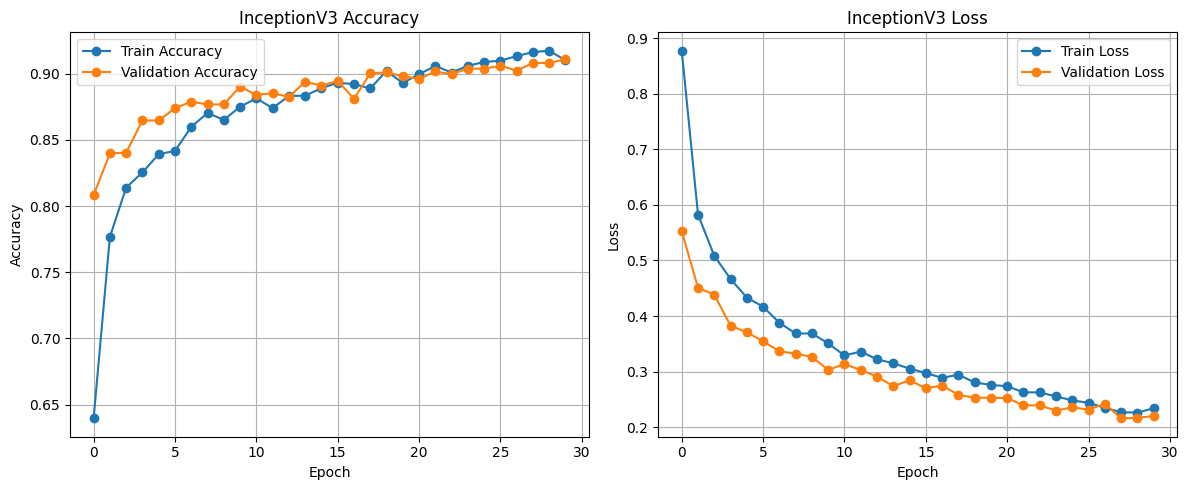

In [ ]:
# ============================================
# Phase 7: Training Visualization
# ============================================

plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='Train Accuracy', marker='o')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy', marker='o')
plt.title('InceptionV3 Accuracy'); plt.xlabel('Epoch'); plt.ylabel('Accuracy'); plt.legend(); plt.grid(True)

plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='Train Loss', marker='o')
plt.plot(history.history['val_loss'], label='Validation Loss', marker='o')
plt.title('InceptionV3 Loss'); plt.xlabel('Epoch'); plt.ylabel('Loss'); plt.legend(); plt.grid(True)

plt.tight_layout(); plt.show()

## 🧪 Phase 8: Model Evaluation

In [ ]:
# ============================================
# Phase 8: Evaluate Model on Test Data
# ============================================

test_loss, test_acc = model.evaluate(test_gen)
print(f"Test Accuracy: {test_acc*100:.2f}%")
print(f"Test Loss: {test_loss:.4f}")

23/23 ━━━━━━━━━━━━━━━━━━━━ 9s 384ms/step - accuracy: 0.8638 - loss: 0.3466
Test Accuracy: 89.93%
Test Loss: 0.2644


## 🧾 Phase 9: Confusion Matrix & Classification Report

23/23 ━━━━━━━━━━━━━━━━━━━━ 15s 369ms/step


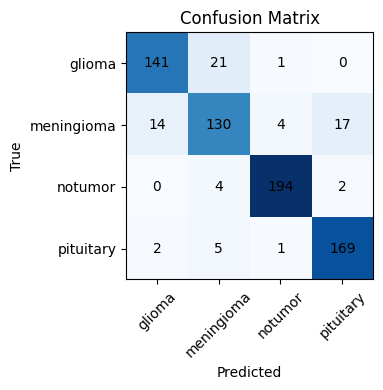

Classification Report:
              precision    recall  f1-score   support

      glioma     0.8981    0.8650    0.8812       163
  meningioma     0.8125    0.7879    0.8000       165
     notumor     0.9700    0.9700    0.9700       200
   pituitary     0.8989    0.9548    0.9260       177

    accuracy                         0.8993       705
   macro avg     0.8949    0.8944    0.8943       705
weighted avg     0.8987    0.8993    0.8987       705



In [ ]:
# ============================================
# Phase 9: Confusion Matrix & Classification Report
# ============================================

y_pred_probs = model.predict(test_gen)
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = test_gen.classes
class_labels = [k for k, v in sorted(test_gen.class_indices.items(), key=lambda kv: kv[1])]

cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(5,4))
plt.imshow(cm, cmap='Blues')
plt.title('Confusion Matrix')
plt.xticks(range(len(class_labels)), class_labels, rotation=45)
plt.yticks(range(len(class_labels)), class_labels)
plt.xlabel('Predicted'); plt.ylabel('True')
for i in range(len(class_labels)):
    for j in range(len(class_labels)):
        plt.text(j, i, cm[i, j], ha='center', va='center', color='black')
plt.tight_layout(); plt.show()

print("Classification Report:")
print(classification_report(y_true, y_pred, target_names=class_labels, digits=4))
